In [51]:
from IPython.display import HTML

HTML(
    '''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>'''
)

In [1]:
run = 'unet_01'

In [2]:
device_use = '/gpu:1'

##### 00. Load Packages

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

def get_available_cpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'CPU']

gpu_list = get_available_gpus()
cpu_list = get_available_cpus()

if len(gpu_list)>0:
    device_use = str(gpu_list[-1])
    print 'Using GPU : ' + device_use
else:
    device_use = str(cpu_list[-1])
    print 'Using CPU : ' + device_use

Using GPU : /gpu:1


In [4]:
%pylab inline


import seaborn as sns
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [5]:
import tensorflow as tf
import keras

import glob as glob
import cv2 as cv2
from tqdm import tqdm
from gc import collect

Using TensorFlow backend.


In [6]:
from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dropout, Activation
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dense,UpSampling2D

from keras.layers.normalization import BatchNormalization

In [7]:
train_files = glob.glob('../01.data/extracted/images_training_rev1/*.jpg')
test_files = glob.glob('../01.data/extracted/images_test_rev1/*.jpg')

##### 00. Define functions

In [8]:
def get_image(image_path,size):
    
    x = cv2.imread(image_path)
    x = cv2.resize(x,size,cv2.INTER_NEAREST)
    return(x)

def get_labels(image_path):
    
    image_id = image_path.split('/')[-1]
    image_number = image_id.split('.')[0]
    values = train_output.loc[np.int(image_number)].values
    
    return(values)

def input_data(image_path):
    
    x = np.array([get_image(image_path)])
    y = np.array([get_labels(image_path)])
    
    return(x,y)

In [9]:
y_path = '../01.data/extracted/training_solutions_rev1.csv'
train_output = pd.read_csv(y_path,index_col='GalaxyID')
train_output.sort_index(inplace=True)

In [16]:
num_classes = 37
epochs = 1500


input_size = (64,64)
img_rows, img_cols = input_size
img_channels = 3
observations,output_classes = train_output.shape

In [17]:
from gc import collect

n = len(train_files)

train_x = np.zeros((n,img_rows,img_cols,img_channels),dtype=np.uint8)
train_y = np.zeros((n,num_classes),dtype=np.float32)

for current_id in tqdm(range(n),miniters=1000):
    
    if current_id%1000==0:
        collect()
        
    current_path = train_files[current_id]
    
    current_image  = np.array(get_image(current_path,input_size))
    current_labels = get_labels(current_path)
    
    train_x[current_id] = current_image
    train_y[current_id] = current_labels
    
    
train_y_expanded = np.expand_dims(np.expand_dims(train_y,1),1)

100%|██████████| 61578/61578 [28:23<00:00, 36.14it/s]  


In [185]:
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)
print('train_y shape:', train_y_expanded.shape)

('train_x shape:', (61578, 64, 64, 3))
('train_y shape:', (61578, 37))
('train_y shape:', (61578, 1, 1, 37))


In [187]:
collect()

0

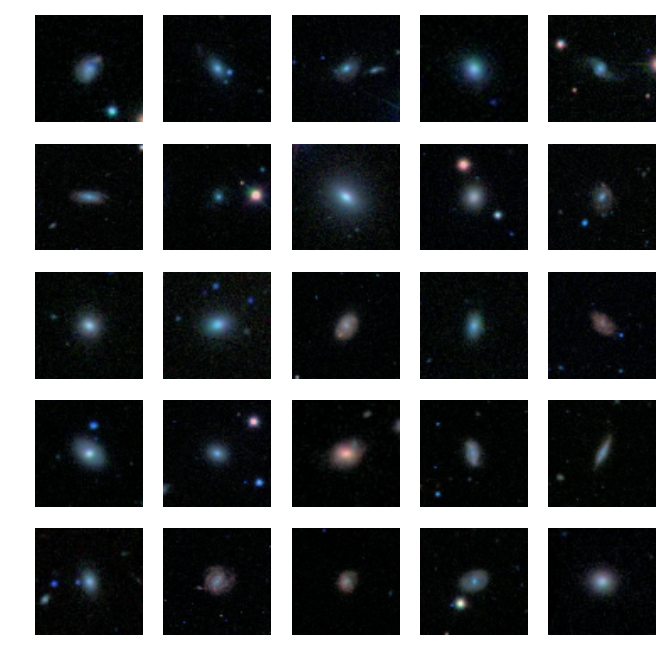

In [48]:
np.random.seed(42)
img_to_plot = 25
samples = np.random.randint(0,1000,img_to_plot)
a = train_x[samples]

plt.figure(figsize=(8,8))
for img_num in range(img_to_plot):
    
    plt.subplot(5,5,img_num+1)
    plt.grid('off')
    plt.imshow((a[img_num]));
    plt.axis('off')

In [49]:
from keras.layers import concatenate


def conv_bn(m, dim, acti, bn):
    
    m = Conv2D(dim, 3, activation=acti, padding='same')(m)
    
    return BatchNormalization()(m) if bn else m

def level_block(m, dim, depth, inc_rate, acti, dropout, bn, fcn):
    
    if depth > 0:
        
        n = conv_bn(m, dim, acti, bn)
        n = Dropout(dropout)(n) if dropout else n
        n = conv_bn(n, dim, acti, bn)
        m = Conv2D(dim, 3, strides=2, activation=acti, padding='same')(n) if fcn else MaxPooling2D()(n)
        m = level_block(m, int(inc_rate*dim), depth-1, inc_rate, acti, dropout, bn, fcn)
        m = UpSampling2D()(m)
        m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        m = concatenate([n, m],axis=3)
    
    m = conv_bn(m, dim, acti, bn)
    
    return conv_bn(m, dim, acti, bn)

def UNet(img_shape, 
         out_ch=1, 
         start_ch=10, 
         depth=4, 
         inc_rate=2, 
         activation='relu', 
         dropout=0.05, 
         bn=False, 
         fcn=False):
    
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, bn, fcn)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)



model_previous = UNet(img_shape=(img_rows,img_cols,img_channels),out_ch=3)

In [50]:
model_previous.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 64, 64, 10)        280       
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 64, 64, 10)        910       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 10)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 32, 32, 20)        1820      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32, 32, 20)        0         
__________

In [52]:
train_batch_size = 2
validation_batch_size = 2

train_steps = 5*train_x.shape[0]/train_batch_size
validation_steps = 0.1 * train_steps

In [53]:
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras_tqdm import TQDMNotebookCallback

tb = TensorBoard(
        log_dir='../tensorboard/'+run+'/',
        write_graph=True,
        write_images=True
    )

mc = ModelCheckpoint(filepath = '../05.model/'+run+'.h5',
                     save_best_only = True)

ec = EarlyStopping(monitor='val_loss',
                   patience=5,
                   mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              min_lr=1e-15)

tqnc = TQDMNotebookCallback(metric_format='{name}: {value:0.4f}')

In [54]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
                                rescale=1.0/255,
                                rotation_range=180,
                                vertical_flip=True,
                                horizontal_flip=True,
                                data_format='channels_last',
                                
)

validation_datagen = ImageDataGenerator(
                                rescale=1.0/255,
                                data_format='channels_last'
)

train_generator = train_datagen.flow(
                                    x=train_x,
                                    y=train_x,
                                    batch_size=train_batch_size
)

validation_generator = validation_datagen.flow(
                                            x=train_x,
                                            y=train_x,
                                            batch_size=validation_batch_size
)

In [180]:
samples = np.array([np.random.randint(0,train_x.shape[0],100) for s in range(615)])
samples = samples.flatten()

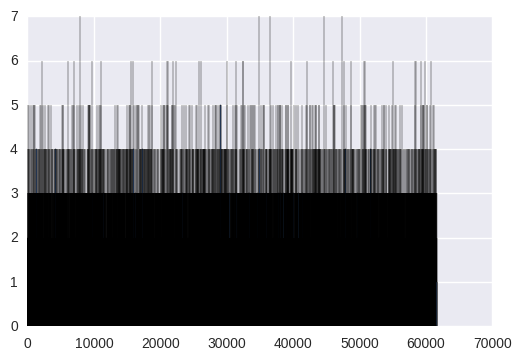

In [184]:
sns.plt.hist(samples,70000);

In [168]:
def custom_processing(img_path,img_size):
    
    img_x = get_image(img_path,img_size)
    img_y = get_labels(img_path)
    
    return(img_x,img_y)
    
def custom_generator(input_paths,
                     batch_size,
                     image_size=input_size):
    
    while True:
        
        # Generate batch
        
        batch_paths = [k for k in random.choice(input_paths,batch_size)]
        batch_features = np.array([
                                  get_image(image_path,image_size) 
                                  for image_path in batch_paths
                                 ])
        batch_labels = np.array([
                                get_labels(image_path) 
                                for image_path in batch_paths
                                ])
        out = (batch_features,batch_labels)
        
        yield batch_features

In [169]:
train_generator = custom_generator(input_paths=train_files[:10],
                                   batch_size=2)

validation_generator = custom_generator(input_paths=train_files,
                                        batch_size=2)

In [ ]:
[list(train_generator) for i in range(2)]

In [172]:
for i in range(2):
    
    print list(train_generator)

[]
[]


In [ ]:
with tf.device(device_use):

    model_previous.compile(loss='mse',
                  optimizer=keras.optimizers.adam(lr=1e-3)
                 )
    
    loss_history = model_previous.fit_generator(
                                    generator=train_generator,
                                    epochs=epochs,
                                    steps_per_epoch=train_steps,
                                    callbacks=[tb,mc,ec,reduce_lr,tqnc],
                                    max_q_size=1,
                                    verbose=1
                )


loss_df = pd.DataFrame(loss_history.history)
loss_df.to_csv('../03.plots/losses/augmented_loss_df'+run+'.csv',
                   index=False)

In [ ]:
with tf.device(device_use):

    model_previous.compile(loss='mse',
                  optimizer=keras.optimizers.adam(lr=1e-3)
                 )
    
    loss_history = model_previous.fit_generator(
                                    generator=train_generator,
                                    validation_data=validation_generator,
                                    epochs=epochs,
                                    steps_per_epoch=train_steps,
                                    validation_steps=validation_steps,
                                    callbacks=[tb,mc,ec,reduce_lr,tqnc],
                                    max_q_size=2,
                                    verbose=1
                )


loss_df = pd.DataFrame(loss_history.history)
loss_df.to_csv('../03.plots/losses/augmented_loss_df'+run+'.csv',
                   index=False)

with tf.device(device_use):

    model.compile(loss='mse',
                  optimizer=keras.optimizers.sgd(lr=1e-1)
                 )
    
    loss_history = model.fit(x=train_x,
                             y=train_x,
                             batch_size=10,
                             validation_split=0.1,
                             callbacks=[tb,mc,ec,reduce_lr,tqnc],
                             epochs=epochs,
                             verbose=0
                            )


loss_df = pd.DataFrame(loss_history.history)
loss_df.to_csv('../03.plots/losses/augmented_loss_df'+run+'.csv',
                   index=False)

$$ \frac{1}{N} \sum_{i=0}^{N} Actual_{i} = Predicted_{i} $$

In [ ]:
data_plot = loss_df.ix[1:,:]
sns.set(style='whitegrid',)
sns.plt.figure(figsize=(7.5,3.5))

plt.plot(data_plot.index,data_plot.loss,label='train')
plt.plot(data_plot.index,data_plot.val_loss,label='validation')
plt.legend()
plt.title('Train & Validation loss');

#### Test data

In [ ]:
out = {}

with tf.device(device_use):  
    for file_path in tqdm(test_files):
        galaxy_id = file_path.split('/')[-1].split('.')[0]
        galaxy_img = np.expand_dims(cv2.resize(cv2.imread(file_path),
                                               input_size),
                                    axis=0)
        galaxy_pred = model.predict(galaxy_img).flatten()

        out[galaxy_id] = galaxy_pred

 67%|██████▋   | 53521/79975 [33:06<14:48, 29.78it/s]  

In [41]:
columns = pd.read_csv(y_path,
                      index_col='GalaxyID',
                      nrows=0)

test_results = pd.DataFrame.from_dict(data = out,
                                      orient='index')
test_results.index.name = 'GalaxyID'
test_results.columns = columns.columns

In [42]:
test_results.to_csv('../04.results/submission'+run+'.csv',
                    index_label='GalaxyID')

## $$t-sne$$

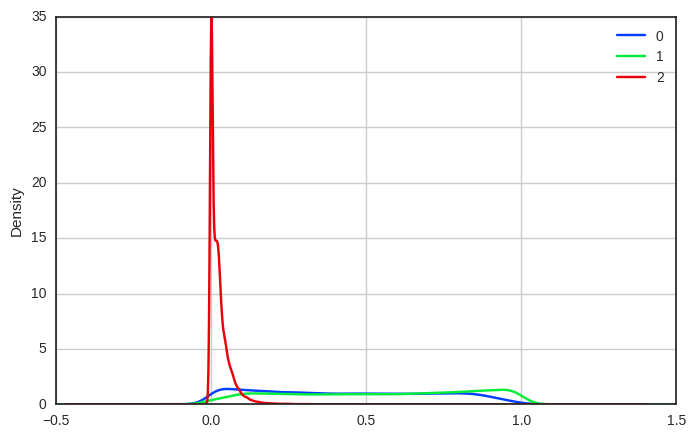

In [71]:
plt.style.use({'figure.figsize':(8,5),'figure.facecolor': 'white'})
pd.DataFrame(train_y[:-1,:3]).plot(kind='kde');
plt.grid('on');

In [ ]:
with tf.device(device_use):
    model = load_model('../05.model/densenet_01.h5')

In [193]:
layer_name = 'global_average_pooling2d_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

In [195]:
from time import time

#import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

with tf.device(device_use):
    X = intermediate_layer_model.predict(train_x,batch_size=100,verbose=1)
    y = np.argmax(train_y[:,:3],axis=1)

61578/61578 [==============================] - 23s    


In [196]:
n_samples, n_features = train_y.shape
n_neighbors = 30

In [197]:
samples = np.random.randint(low=0,high=50000,size=10**4)

In [ ]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X[samples])

In [200]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(15,15))
    ax = plt.subplot(111)

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-5:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(cv2.resize(train_x[i],
                                                 (32,32)), alpha=.75,
                                      cmap=plt.cm.gray_r),
                X[i],pad=0.001)
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [ ]:
sns.set(style='white')
sns.plt.figure(figsize=(10,10))

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))
#plt.savefig('../03.plots/tsne_v1.png',dpi=250)

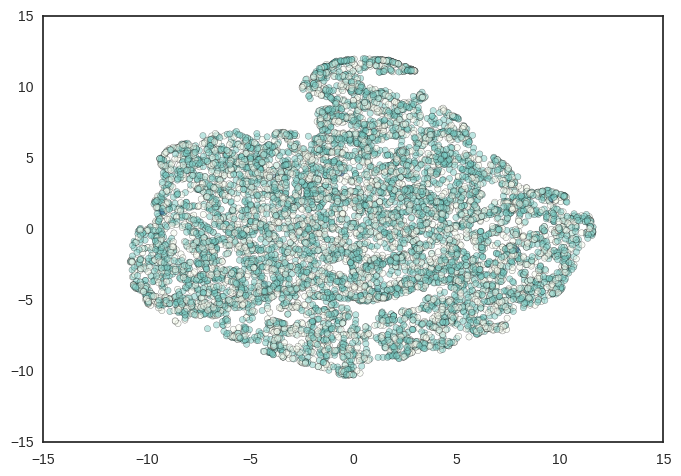

In [229]:
k = 10000

plt.scatter(X_tsne[:k,0],
            X_tsne[:k,1],
            c=y[:k],
            cmap='GnBu',
            alpha=0.5);